# LSTM to predict future stock prices - **Version 2.0**

*Code developep for learning the process viewed in this blog and repository:*
* https://medium.com/visionary-hub/using-lstms-to-predict-future-stock-prices-61f4458fc860

* https://github.com/fazalmittu/StockPricePredictor/blob/main/StockPricePredictorProject.ipynb

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
# For represent the data
import matplotlib.pyplot as plt
# For scale the data before introduce in neural network
from sklearn.preprocessing import MinMaxScaler
# For create the model with sequential (model.add())
from tensorflow.keras.models import Sequential
# For create the architecture of the neural network
from tensorflow.keras.layers import Dense, LSTM, Dropout
# For represent learning curves
import matplotlib as mpl
# Metrics
# For obtain the root MSE
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error #Best way

In [2]:
# Checking GPU 

physical_devices = tf.config.list_physical_devices('GPU')
print(f"Resultado physical devices: {physical_devices}")
print("Num GPUs: ", len(physical_devices))
print("GPU disponible en: ", tf.test.is_gpu_available)

Resultado physical devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs:  1
GPU disponible en:  <function is_gpu_available at 0x000001FEAFE4D2D0>


In [3]:
df = pd.read_csv(r"data/AAPL.csv")
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-03-02,70.570000,75.360001,69.430000,74.702499,73.581810,341397200
1,2020-03-03,75.917503,76.000000,71.449997,72.330002,71.244896,319475600
2,2020-03-04,74.110001,75.849998,73.282501,75.684998,74.549568,219178400
3,2020-03-05,73.879997,74.887497,72.852501,73.230003,72.131393,187572800
4,2020-03-06,70.500000,72.705002,70.307503,72.257500,71.173485,226176800


In [4]:
# Convert to datatime 
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df = df.drop(['Date'], axis=1)
print(f"Length for the data: {len(df)}")
df.head(5)

Length for the data: 252


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-02,70.570000,75.360001,69.430000,74.702499,73.581810,341397200
2020-03-03,75.917503,76.000000,71.449997,72.330002,71.244896,319475600
2020-03-04,74.110001,75.849998,73.282501,75.684998,74.549568,219178400
2020-03-05,73.879997,74.887497,72.852501,73.230003,72.131393,187572800
2020-03-06,70.500000,72.705002,70.307503,72.257500,71.173485,226176800


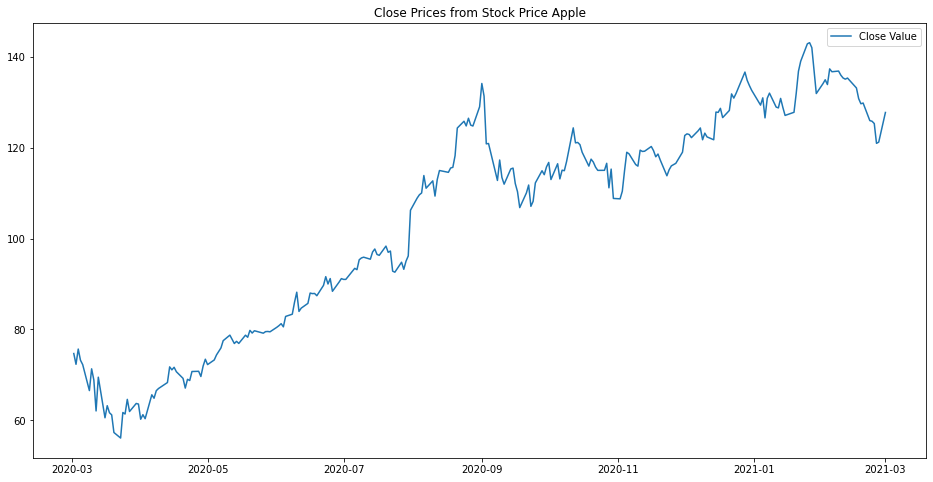

In [5]:
# Represent data
plt.figure(figsize=(16,8))
plt.title("Close Prices from Stock Price Apple")
plt.plot(df['Close'], label='Close Value')
plt.legend(loc='best')
plt.show()

# Data processing

In [6]:
# La variable de interes es lo que me interesa, las otras no

# We only want the target feature
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df.head(5)

,Close
Date,
2020-03-02,74.702499
2020-03-03,72.330002
2020-03-04,75.684998
2020-03-05,73.230003
2020-03-06,72.257500


In [7]:
# La secuencia es muy importante en Time series forecasting, LSTM, GRU, etc. Por ello no se puede usar 
# train_test_split ya que esta hace la division de manera aleatoria y haciendo un shuffle y esto es lo 
# que queremos evitar

size_data = len(df)
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
print(f"El tamaño Total de la secuencia es de: {size_data}")
print(f"El tamaño de secuencia establecido para Train es de: {train_size}")
print(f"El tamaño de secuencia establecido para Test es de: {test_size}")

El tamaño Total de la secuencia es de: 252
El tamaño de secuencia establecido para Train es de: 168
El tamaño de secuencia establecido para Test es de: 84


## Changing Type

In [8]:
print(type(df))
print(type(df.values))
print(type(df.astype('float32')))
# Es hacer lo mismo? Por tanto este paso sería incesesario??
# SÍ QUE ES NECESARIO PORQUE SINO NO SE PUEDE HACER LA DIVISON EN TRAIN, TEST

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [9]:
df = df.values
df = df.astype('float32')

## Scaling Data

In [10]:
# Scale the data

scaler = MinMaxScaler(feature_range = (0,1))
df = scaler.fit_transform(df)
df[0:5]

array([[0.21374226],
       [0.18649328],
       [0.22502655],
       [0.1968301 ],
       [0.1856606 ]], dtype=float32)

In [11]:
# Creamos set de training y de validacion

Train = df[0:train_size, :]
Test = df[train_size:len(df), :]
print(f"Los datos para Train, son los siguientes:\n")
print(Train[0:5])
print("\n\n")
print(f"Los datos para Test, son los siguientes:\n")
print(Test[0:5])

Los datos para Train, son los siguientes:

[[0.21374226]
 [0.18649328]
 [0.22502655]
 [0.1968301 ]
 [0.1856606 ]]



Los datos para Test, son los siguientes:

[[0.6329285 ]
 [0.680248  ]
 [0.60605276]
 [0.6050191 ]
 [0.6241996 ]]


## New sequence of data

In [12]:
# look_back is window time, which time we want to predict

def Create_Dataset(dataset, look_back):
    # Create two empty list
    DataX, DataY = [], []
    # Fill the list with the new sequence with the window
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i: (i + look_back), 0]
        DataX.append(a)
        DataY.append(dataset[i + look_back, 0])
    # Return an array of the new sequence 
    return np.array(DataX), np.array(DataY)

In [13]:
# Establecemos la ventana de predicción, cuantos puntos en el futuro predeciremos
# Es decir al ser 10, y estoy en la posición 1, pues a partir de la posición 1 intentaré
# predecir la posición 11. Otra cosa el time_steps que nos dirá cuantos puntos tengo en 
# cuenta para hacer esa predicción que busco
look_back = 10

# Creamos secuencias para train y test
TrainX, TrainY = Create_Dataset(Train, look_back)
TestX, TestY = Create_Dataset(Test, look_back)

# Observamos los datos
for i in range(5):
    print(TrainX[i], TrainY[i])

[0.21374226 0.18649328 0.22502655 0.1968301  0.1856606  0.12002188
 0.17506534 0.14661038 0.06851006 0.1539036 ] 0.05122465
[0.18649328 0.22502655 0.1968301  0.1856606  0.12002188 0.17506534
 0.14661038 0.06851006 0.1539036  0.05122465] 0.081804395
[0.22502655 0.1968301  0.1856606  0.12002188 0.17506534 0.14661038
 0.06851006 0.1539036  0.05122465 0.08180439] 0.064030826
[0.1968301  0.1856606  0.12002188 0.17506534 0.14661038 0.06851006
 0.1539036  0.05122465 0.08180439 0.06403083] 0.058604002
[0.1856606  0.12002188 0.17506534 0.14661038 0.06851006 0.1539036
 0.05122465 0.08180439 0.06403083 0.058604  ] 0.0139834285


## Reshape Entry Data

In [14]:
# Las redes LSTM, se esperan una entrada del estilo: [samples, time-steps, features] 
# pero actualemente nuestros sets de datos tienen este tipo de shape [samples, features], comprobamos:

print(f"El shape para el set de training es: {TrainX.shape}")
print(f"El shape para el set de test es: {TestX.shape}")

El shape para el set de training es: (157, 10)
El shape para el set de test es: (73, 10)


In [15]:
# Por tanto se debe readaptar el shape antes de introducir a la red, por ello se hace lo siguiente.
# Pero el time-step, que valor debe tener? Es correcto pensar que se trata de las muestras a tener 
# en cuenta para realizar la prediccion para una ventana temporal ya establecida. Es decir para 
# predicir la posición que tengo a 10 posiciones adelante, voy a mirar 5 (time-steps) anteriores 
# a mi para intentar predecir.
# ------ CHECKEAR SI ESTO ES ACERTADO -----------------


# Resehape entry data
# [samples, time-steps, features]
time_steps = 1
TrainX = np.reshape(TrainX, (TrainX.shape[0], time_steps, TrainX.shape[1]))
TestX = np.reshape(TestX, (TestX.shape[0], time_steps, TestX.shape[1]))
print(f"El shape para el set de training es: {TrainX.shape}")
print(f"El shape para el set de test es: {TestX.shape}")

El shape para el set de training es: (157, 1, 10)
El shape para el set de test es: (73, 1, 10)


# Model Architecture

In [16]:
model = Sequential()
# Why in this case, input shape is 60,1?? - In the other model of power consumption was the same but diferent value, last_n
# input_shape = 1 entrada que será una tupla más la ventana temporal a utilizar
model.add(LSTM(units = 1000, return_sequences = True, input_shape=(1, look_back)))
model.add(LSTM(units = 1000, return_sequences = True))
model.add(LSTM(units = 1000))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1, 1000)           8004000   
                                                                 
 lstm_2 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 20,053,001
Trainable params: 20,053,001
Non-trainable params: 0
_________________________________________________________________


# Training Process

In [17]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(TrainX, TrainY, epochs=100, verbose=1)

Epoch 1/100
5/5 [==============================] - 5s 17ms/step - loss: 0.1553
Epoch 2/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0357
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0293
Epoch 4/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0142
Epoch 5/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0128
Epoch 6/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0099
Epoch 7/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0052
Epoch 8/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0046
Epoch 9/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0038
Epoch 10/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0029
Epoch 11/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0027
Epoch 12/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0027
Epoch 13/100
5/5 [==============================]

In [18]:
import matplotlib as mpl

def plot_learning_curves(loss):
    plt.figure(figsize=(15,5))
    plt.title('Learning Curves')
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    # plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True)) # mlp is matplotlib as mpl - 
    plt.axis([1, len(loss), 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

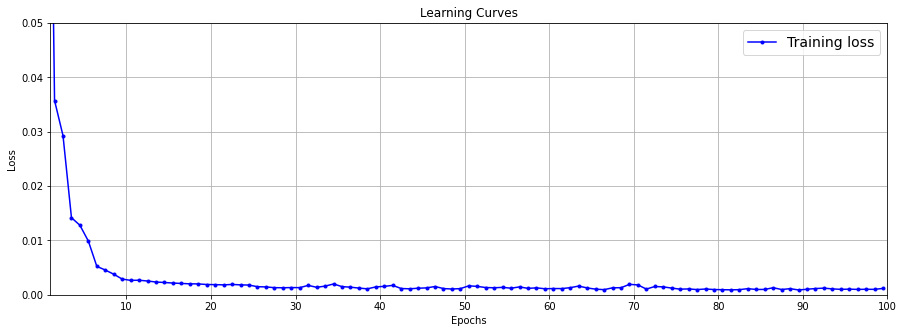

In [19]:
plot_learning_curves(history.history["loss"])

# Evaluation

In [20]:
# Se realiza la predicción de los sets
TrainPredict = model.predict(TrainX)
TestPredict = model.predict(TestX)
print("\n")
for i in range(3):
    print(TrainPredict[i], TestPredict[i])

3/3 [==============================] - 0s 5ms/step


[0.13441074] [0.7061521]
[0.10292628] [0.7198916]
[0.08180282] [0.7323017]


In [21]:
# Se realiza la inversa de la normalización para obtener los datos en escala correcta
# Tanto para Predicciones como para los datos de entrada para representar más adelante
TrainPredict_inverse = scaler.inverse_transform(TrainPredict)
TestPredict_inverse = scaler.inverse_transform(TestPredict)

# <--- WARNING --->
# Para TrainY y TestY se debe pasar como lista por eso se utiliza '[]'
TrainY = scaler.inverse_transform([TrainY]) 
TestY = scaler.inverse_transform([TestY])

print("\n")
for i in range(3):
    print(TrainPredict_inverse[i], TestPredict_inverse[i])



[67.7953] [117.57539]
[65.05403] [118.77167]
[63.214867] [119.85218]


In [25]:
# Se obtiene el score de root MSE
TrainScore = round(mean_absolute_percentage_error(TrainY[0], TrainPredict_inverse[:, 0]),3)
print(f"El error porcentual absoluto medio (MAPE) para training es: {TrainScore} %")

TestScore = round(mean_absolute_percentage_error(TestY[0], TestPredict_inverse[:, 0]),3)
print(f"El error porcentual absoluto medio (MAPE) para test es: {TestScore} %")

El error porcentual absoluto medio (MAPE) para training es: 0.021 %
El error porcentual absoluto medio (MAPE) para test es: 0.015 %


In [28]:
############### RRMSE Calculation #################

def relative_root_mean_squared_error(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss
############### RRMSE Calculation ###################

In [27]:
# Se obtiene el score de root MSE
TrainScore = round(relative_root_mean_squared_error(TrainY[0], TrainPredict_inverse[:, 0]),3)
print(f"El RRMSE para training es: {TrainScore} %")

TestScore = round(relative_root_mean_squared_error(TestY[0], TestPredict_inverse[:, 0]),3)
print(f"El RRMSE para test es: {TestScore} %")

El RRMSE para training es: 0.028 %
El RRMSE para test es: 0.02 %


In [23]:
# Se debe reformatear para representar
TrainPredictPlot = np.empty_like(df)

# Se marcan todas las filas y columnas como nan
TrainPredictPlot[: , :] = np.nan

# Introducir mis predicciones a partir de la fila de mi ventana 
# temporal hasta la longitud de mis predicciones mas mi ventana
# hacer esto con todas las columnas
TrainPredictPlot[look_back:len(TrainPredict_inverse) + look_back, :] = TrainPredict_inverse 

# Hacer lo mismo para Test
TestPredictPlot = np.empty_like(df)
TestPredictPlot[:, :] = np.nan
TestPredictPlot[len(TrainPredict_inverse) + (look_back * 2) + 1: len(df) - 1, :] = TestPredict_inverse

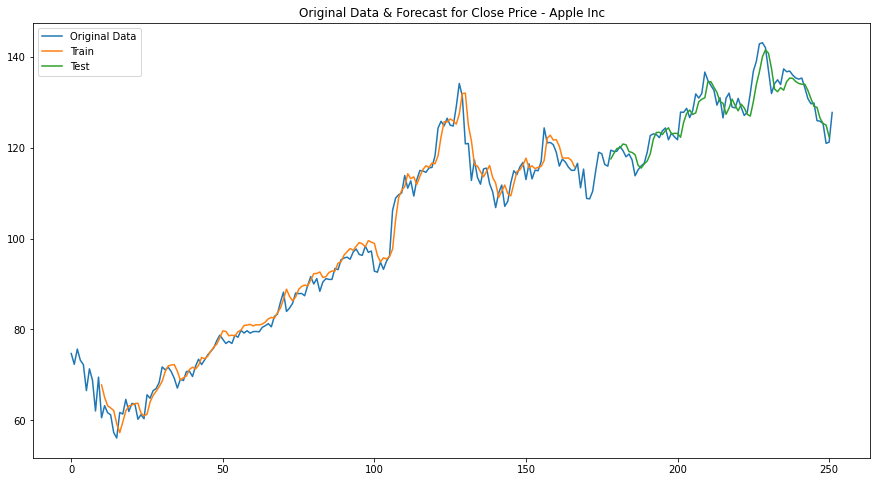

In [24]:
# Plot

plt.figure(figsize=(15,8))
plt.title('Original Data & Forecast for Close Price - Apple Inc')
plt.plot(scaler.inverse_transform(df), label = 'Original Data')
plt.plot(TrainPredictPlot, label='Train')
plt.plot(TestPredictPlot, label='Test')
plt.legend(loc='best')
plt.show()